Today I will look at the differences in features of songs I like and dislike. Along the way to a nice, pretty graph of song features, this post shows how to extract features from songs contained in spotify playlists. It makes use of the *__Spotipy__* Python library to access the Spotify Web API. What's nice about this library is that it contains easy helper methods to access different data from the API. For example, I use the `user_playlist_tracks` and `audio_features` methods.

## Step 1: access the Spotify API

Because I am trying to get data from my specific user account the methods I want to use from Spotipy require authentication. That means I need to generate an authorization token which indicates the user has granted me permission to perform specific tasks from my application (my code). Basically, I need to send a request to myself to authenticate myself. This is all handled simply with Spotipy's `util.prompt_for_user_token`, which will coordinate the authorization with the web browser (pass the client credentials, ask the user for access, return the granted access via a token). [Spotipy's documentation](https://spotipy.readthedocs.io/en/latest/) explains it a lot better than me.

In [1]:
import spotipy
import spotipy.util as util
from config import client_id, client_secret, redirect_uri, username, good_playlist_id, bad_playlist_id
import numpy as np
import pandas as pd

scope = 'user-library-read playlist-read-private'
token = util.prompt_for_user_token(username, scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

## Step 2: get list of track IDs from a playlist

In this case, I am grabbing track IDs from my "good songs" playlist and my "bad songs" playlist. The Spotify API only lets you grab 100 tracks at a time so you have to use a `while` loop where `results['next']` is true/false.

In [2]:
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

Here I convert the raw JSON data from the API request into a dataframe so I can make sure I have the good and bad playlists labelled correctly. There really was no other reason to put it into a dataframe other than to see the data nicely in a table! I could have just collected the IDs into an array because that is all I need to pull the features for each song.

In [3]:
def tracks_to_df(username, playlist_id, data_array):
    tracks = get_playlist_tracks(username, playlist_id)
    for i in range(len(tracks)):
        row = [tracks[i]['track']['id'],
              tracks[i]['track']['name'],
              tracks[i]['track']['popularity']]
        data_array.append(row)
        
    data_df = pd.DataFrame(data=data_array,columns=['id','name','popularity'])
    return data_df

### Pull good tracks

In [4]:
data_good = []
df_good = tracks_to_df(username, good_playlist_id, data_good)

df_good.head()

,id,name,popularity
0,6wQYKyGePaqstYov2C1S5b,C'est La Vie,40
1,0byab45cmZntz74RxcASrf,Close To Me (with Diplo) (feat. Swae Lee) - Fe...,28
2,40xLrjniJVkxuWbka7KavC,Decisions (feat. Maia Wright),65
3,3FClUxQc36bQc6kNlXzadI,Don't You Know,40
4,2yuoF9C4QF9kCsoDf3yUHP,Feel the Same - EDX Dubai Skyline Remix Edit,49


### Pull bad tracks

In [5]:
data_bad = []
df_bad = tracks_to_df(username, bad_playlist_id, data_bad)

df_bad.head()

,id,name,popularity
0,2Fxmhks0bxGSBdJ92vM42m,bad guy,95
1,6MWtB6iiXyIwun0YzU6DFP,Wow.,88
2,4y3OI86AEP6PQoDE6olYhO,Sucker,88
3,5p7ujcrUXASCNwRaWNHR1C,Without Me,87
4,6u7jPi22kF8CTQ3rb9DHE7,Old Town Road (feat. Billy Ray Cyrus) - Remix,94


### Save the track IDs

Because the `audio_features` method only lets you pull track features for 50 tracks at a time, I have had to write a method to split the array of IDs into chunks of 50.

In [6]:
def chunks(mylist, chunk_size):
    # For item i in a range that is a length of l,
    for i in range(0, len(mylist), chunk_size):
        # Create an index range for l of n items:
        yield mylist[i:i+chunk_size]

In [7]:
good_ids=df_good['id'].tolist()
bad_ids=df_bad['id'].tolist()

## Step 3: get track features

In [8]:
def features_to_df(ids, data_array):
    # Create a list from the results of the function chunks, get features for batch of ids, append to array
    for i in range(0, len(list(chunks(ids, 50)))):
        ids_batch = list(chunks(ids, 50))[i]
        features_temp = sp.audio_features(tracks=ids_batch)
        data_array.append(features_temp)

    columns = list(data_array[0][0].keys())
    columns.sort()

    # convert to df
    # instantiate empty dataframe
    df_features = pd.DataFrame(columns = columns)

    for i in range(0, len(data_array)):
        df_temp = pd.DataFrame(data_array[i], columns = columns)
        df_features = df_features.append(df_temp, ignore_index=True)
    
    return df_features

### Pull good features

In [9]:
good_features = []
df_features_good = features_to_df(good_ids, good_features)

df_features_good.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.0383,https://api.spotify.com/v1/audio-analysis/6wQY...,0.839,171375,0.613,6wQYKyGePaqstYov2C1S5b,0.000000,2,0.323,-6.457,1,0.0463,125.011,4,https://api.spotify.com/v1/tracks/6wQYKyGePaqs...,audio_features,spotify:track:6wQYKyGePaqstYov2C1S5b,0.667
1,0.0145,https://api.spotify.com/v1/audio-analysis/0bya...,0.733,223533,0.839,0byab45cmZntz74RxcASrf,0.000187,1,0.162,-2.840,0,0.0335,126.009,4,https://api.spotify.com/v1/tracks/0byab45cmZnt...,audio_features,spotify:track:0byab45cmZntz74RxcASrf,0.471
2,0.0534,https://api.spotify.com/v1/audio-analysis/40xL...,0.732,212788,0.785,40xLrjniJVkxuWbka7KavC,0.000048,0,0.388,-5.081,1,0.0470,121.987,4,https://api.spotify.com/v1/tracks/40xLrjniJVkx...,audio_features,spotify:track:40xLrjniJVkxuWbka7KavC,0.256
3,0.0933,https://api.spotify.com/v1/audio-analysis/3FCl...,0.761,203976,0.696,3FClUxQc36bQc6kNlXzadI,0.168000,6,0.158,-6.837,1,0.1270,124.002,4,https://api.spotify.com/v1/tracks/3FClUxQc36bQ...,audio_features,spotify:track:3FClUxQc36bQc6kNlXzadI,0.664
4,0.3100,https://api.spotify.com/v1/audio-analysis/2yuo...,0.876,209634,0.741,2yuoF9C4QF9kCsoDf3yUHP,0.018500,11,0.110,-4.836,0,0.0435,122.967,4,https://api.spotify.com/v1/tracks/2yuoF9C4QF9k...,audio_features,spotify:track:2yuoF9C4QF9kCsoDf3yUHP,0.695


### Pull bad features

In [10]:
bad_features = []
df_features_bad = features_to_df(bad_ids, bad_features)

df_features_bad.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.3280,https://api.spotify.com/v1/audio-analysis/2Fxm...,0.701,194088,0.425,2Fxmhks0bxGSBdJ92vM42m,0.130000,7,0.1000,-10.965,1,0.3750,135.128,4,https://api.spotify.com/v1/tracks/2Fxmhks0bxGS...,audio_features,spotify:track:2Fxmhks0bxGSBdJ92vM42m,0.562
1,0.1630,https://api.spotify.com/v1/audio-analysis/6MWt...,0.833,149520,0.539,6MWtB6iiXyIwun0YzU6DFP,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,audio_features,spotify:track:6MWtB6iiXyIwun0YzU6DFP,0.385
2,0.0427,https://api.spotify.com/v1/audio-analysis/4y3O...,0.842,181040,0.734,4y3OI86AEP6PQoDE6olYhO,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,https://api.spotify.com/v1/tracks/4y3OI86AEP6P...,audio_features,spotify:track:4y3OI86AEP6PQoDE6olYhO,0.952
3,0.2970,https://api.spotify.com/v1/audio-analysis/5p7u...,0.752,201661,0.488,5p7ujcrUXASCNwRaWNHR1C,0.000009,6,0.0936,-7.050,1,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533
4,0.0533,https://api.spotify.com/v1/audio-analysis/6u7j...,0.878,157067,0.619,6u7jPi22kF8CTQ3rb9DHE7,0.000000,6,0.1130,-5.560,1,0.1020,136.041,4,https://api.spotify.com/v1/tracks/6u7jPi22kF8C...,audio_features,spotify:track:6u7jPi22kF8CTQ3rb9DHE7,0.639


## Step 4: plot the distribution of features for good and bad tracks

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

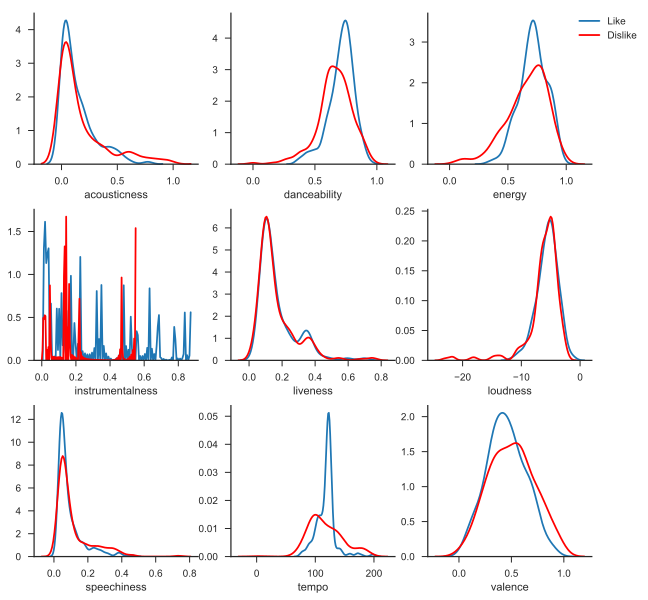

In [12]:
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("tab10")
sns.set_style("ticks")

f, axes = plt.subplots(3, 3, figsize=(10,10))

sns.despine(fig=f, ax=axes)

# this could be refactored majorly lol
sns.distplot(df_features_good['acousticness'], hist=False, ax=axes[0,0]);
sns.distplot(df_features_bad['acousticness'], hist=False, ax=axes[0,0], color='red');
sns.distplot(df_features_good['danceability'], hist=False, ax=axes[0,1]);
sns.distplot(df_features_bad['danceability'], hist=False, ax=axes[0,1], color='red');
sns.distplot(df_features_good['energy'], hist=False, ax=axes[0,2], label='Like');
sns.distplot(df_features_bad['energy'], hist=False, ax=axes[0,2], color='red', label='Dislike');

sns.distplot(df_features_good['instrumentalness'], hist=False, ax=axes[1,0]);
sns.distplot(df_features_bad['instrumentalness'], hist=False, ax=axes[1,0], color='red');
sns.distplot(df_features_good['liveness'], hist=False, ax=axes[1,1]);
sns.distplot(df_features_bad['liveness'], hist=False, ax=axes[1,1], color='red');
sns.distplot(df_features_good['loudness'], hist=False, ax=axes[1,2]);
sns.distplot(df_features_bad['loudness'], hist=False, ax=axes[1,2], color='red');

sns.distplot(df_features_good['speechiness'], hist=False, ax=axes[2,0]);
sns.distplot(df_features_bad['speechiness'], hist=False, ax=axes[2,0], color='red');
sns.distplot(df_features_good['tempo'], hist=False, ax=axes[2,1]);
sns.distplot(df_features_bad['tempo'], hist=False, ax=axes[2,1], color='red');
sns.distplot(df_features_good['valence'], hist=False, ax=axes[2,2]);
sns.distplot(df_features_bad['valence'], hist=False, ax=axes[2,2], color='red');

plt.subplots_adjust(hspace = 0.3)

# put legend on one subplot
axes[0,2].legend(['Like', 'Dislike'], bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.)

%config InlineBackend.figure_format = 'svg'

## Interpretation

I've plotted the features of the good and bad songs in overlayed distribution charts to see if there are any clear differences. Immediately I can see the most variation in danceability, energy, tempo and valence. That there is variation across my good and bad playlists is positive for when I input these features into a classification algorithm in order to create my own Spotify Weekly playlist. The songs I like tend to have higher danceability, energy and tempo, but less valence. Spotify's API gives some nice definitions of these features:

- __Danceability__: "...how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity."
- __Energy__: "...a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy."
- __Tempo__: pace of the track in beats per minute (BPM)
- __Valence__: "...musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric)..."

The other features do not seem as meaninful. There is virtually no variation in liveness or loudness across good and bad songs. This kind of makes sense since most of the songs in both of these playlists are pop/electronic songs. There are small differences for the acousticness and speechiness features. This also makes sense because none of these songs have any "spoken word" attributes like podcasts would have (speechiness) and they don't have acoustic guitar (except for maybe some of the P!nk songs I threw into the "bad" category).

## The F u t u r e

My next post will use the song features from my good and bad playlists to create a customized Discover Weekly playlist (or just filter the already-created Discover Weekly playlist that Spotify generates). Similar to [this post](https://towardsdatascience.com/making-your-own-discover-weekly-f1ac7546fedb) I will get different classification algorithms such as Decision Trees, K-Nearest Neighbors, Adaptive Boosting or Gradient Boosting to predict which songs I will like.